In [2]:
import pretty_midi as pm
import matplotlib.pyplot as plt
import midi_processing
from importlib import reload

reload(midi_processing)

dat2mid_anna=midi_processing.dat2mid_anna

# function to midi image
def midi_image(tokens):
    # read in midi file
    midi_data=dat2mid_anna(tokens+[])
    # get piano roll
    piano_roll =  midi_data.get_piano_roll(fs=100) # shape=(pitch, timestep)
    # plot the piano roll with length of yaxis=xaxis
    
    plt.imshow(piano_roll, aspect='auto', origin='lower')
    plt.show()


In [3]:
# read pickle data_file 
import pickle
print("Reading data from pickle file...")
with open("Store/asap-dataset/train_data.pickle", 'rb') as f:
    data=pickle.load(f)
print("Completed reading")

Reading data from pickle file...
Completed reading


In [1]:
from collections import Counter
import json
import random
import torch
import pickle
import pandas as pd
import random 

random.seed(42)

from datasets import MidiPerformanceDataset

In [4]:
data_file="Store/asap-dataset/test_data.pickle"
dataset = MidiPerformanceDataset(data_file)


Reading data from pickle file...
Completed reading


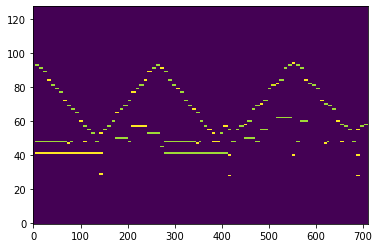

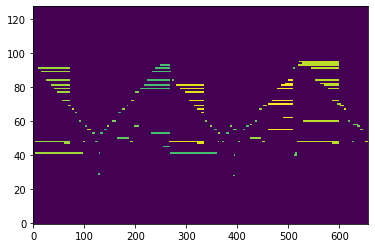

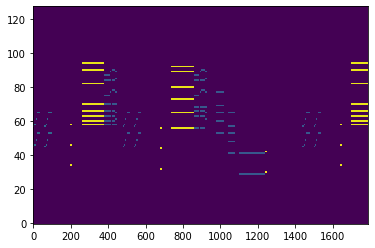

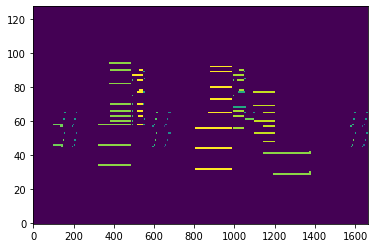

tensor([[10.0000,  1.9531],
        [33.0000,  6.4453]])


In [5]:
batch = dataset.get_batch(2,show=True)
# print diffrence between score and performance
print(batch["diff"])

In [9]:
D1 = Counter({'A': 2, 'B': 1, 'C': 4, 'D': 5, 'E': 5})
D2 = Counter({'A': 3, 'B': 4, 'C': 4, 'D': 7, 'E': 3})

diff1=D1-D2
diff2=D2-D1

print((D1-D2)+(D2-D1))

Counter({'B': 3, 'E': 2, 'D': 2, 'A': 1})
